# 비트코인 시세 예측하기

1. 시간정보가 포함된 데이터 살펴보기
2. 파이썬 라이브러리를 활용한 시세 예측
3. 더 나은 결과를 위한 방법들
    * 상한가 및 하한가 선정
    * 이상치 제거하기
    * 하이퍼 파라미터 선정하기
4. 재미로 알아보는 내일의 비트코인 시세
5. [블락체인](https://www.blockchain.com/ko/charts/market-price?timespan=60days)

In [214]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython. display import Image
import warnings
warnings.filterwarnings("ignore")

# 1. 시간정보가 포함된 데이터 살펴보기

In [2]:
# market price 데이터셋의 기본 정보]
file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [3]:
print(bitcoin_df.shape)
print(bitcoin_df.info())

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [4]:
bitcoin_df.tail()

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


### 시계열 데이터 살펴보기

In [5]:
# to_datetime으로 day 피처를 시계열 피처로 변환 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

In [6]:
# day 데이터프레임의 index로 설정
bitcoin_df.index = bitcoin_df['day']

In [7]:
bitcoin_df.set_index('day', inplace=True)

In [8]:
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [9]:
bitcoin_df.describe()

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


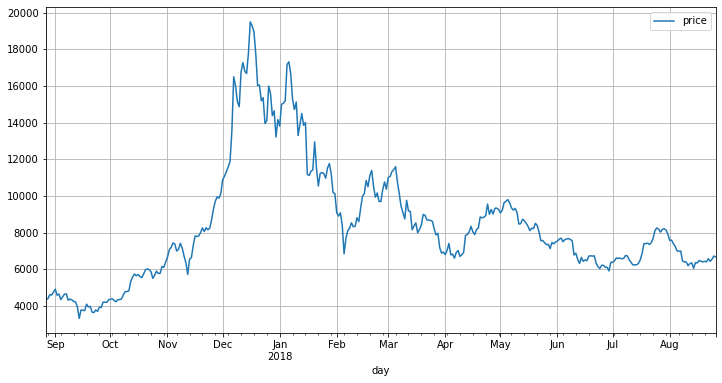

In [10]:
# 일자별 비트코인 시세 시각화
bitcoin_df.plot(figsize = (12, 6), grid =True)
plt.show()

# 2. 파이썬 라이브러리를 활용한 시세 예측

###### ARIMA 모델 학습
* AR(Autoregression 모델) : 자신의 과거를 정보로 사용, 현재 상태는 이전의 상태를 참고해서 계산
* MA(Moving Average 모델) : 이전 항에서의 오차를 이용하여 현재 항의 상태를 추론
* ARIMA(Autoregressive Integrated Moving Average 모델) : ARMA 모델에 추세 변동의 경향성 까지 반영
* 별도 연구 필요함.(시계열 자료)

In [11]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

### (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델 학습
### AR이 몇 번째 과거까지의 과거를 바라보는지에 대한 파라메터(2)
### 차분(Difference)에 대한 파라미터(1) 
### 차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미, 
### 시계열 데이터의 불규칙성을 보정해 주는 역할을 함
### MA가 몇 번째 과거까지를 바라보는지에 대한 파라메터(2) 

In [12]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)# c - constant, disp : 수렴정보를 나타냄.
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Tue, 15 Dec 2020   AIC                           5587.107
Time:                        14:51:35   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3505     27.794      0.228      0.819     -48.125      60.826
ar.L1.D.y     -0.3787      1.825     -0.207      0.836      -3.956       3.199
ar.L2.D.y      0.1586      1.190      0.133      0.8

###### 모델의 성능 & 예측 결과 시각화
- 학습한 모델이 학습 데이터에 대해서 예측한 결과 시각화

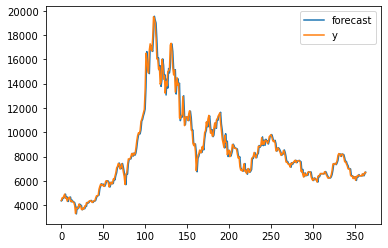

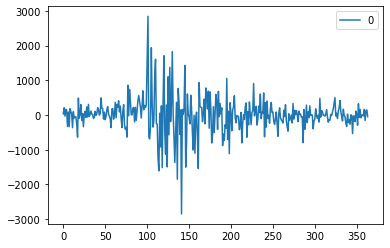

In [13]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과(1)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화(2)
#폭이 일정하다면 좋은 예측 모델-그러나 실행 결과에서 오차 변동이 매우 불안정한 것으로 보임
residuals.plot()

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days)하여 직접 만든 모델로 마음대로의 기간으로 예측해 보세요.

In [14]:
# 학습 데이터셋으로부터 5일 뒤를 예측
forecast_data = model_fit.forecast(steps=5) 

# 5일 후의 실제 데이터는 테스트 데이터셋으로 불러옴
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터(2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터(2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

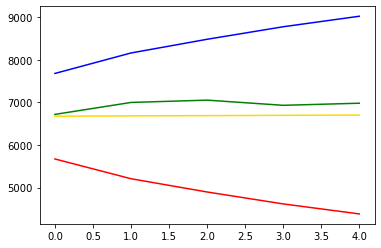

In [15]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

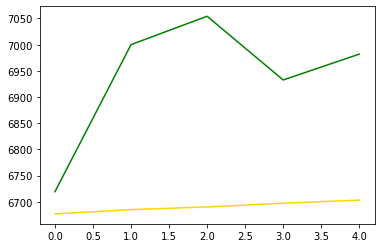

In [16]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

270.7583100083765


예상이 정확하지는 않지만 , 5일동안 상승할 것이다.

### [Facebook Prophet 활용]

- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미       비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋습니다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측, 수치가 높을수록 overfitting에 가까워짐

###### Prophet 모델 학습

In [18]:
from fbprophet import Prophet

In [19]:
# prophet을 사용하기 위해 피처의 이름 변경: 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

###### 모델로부터 예측할 기간을 정의하고, 결과 도출

In [20]:
# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [21]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,738.543896,6241.608803,7620.952336,738.543896,738.543896,9.563964,9.563964,9.563964,8.374726,...,-0.006602,-0.006602,-0.006602,-1.182636,-1.182636,-1.182636,0.0,0.0,0.0,6923.647020
366,2018-08-28,742.612648,6307.903748,7715.261027,742.612648,742.612648,9.563964,9.563964,9.563964,8.452304,...,0.019974,0.019974,0.019974,-1.131634,-1.131634,-1.131634,0.0,0.0,0.0,7019.400574
367,2018-08-29,746.681400,6345.769990,7734.349490,746.681400,746.681400,9.563964,9.563964,9.563964,8.421478,...,-0.046634,-0.046634,-0.046634,-1.095851,-1.095851,-1.095851,0.0,0.0,0.0,7034.842537
368,2018-08-30,750.750152,6352.264916,7861.636061,748.339334,755.596575,9.563964,9.563964,9.563964,8.468117,...,-0.017649,-0.017649,-0.017649,-1.078198,-1.078198,-1.078198,0.0,0.0,0.0,7108.190099
369,2018-08-31,754.818904,6376.382718,7949.905905,746.118475,771.228595,9.563964,9.563964,9.563964,8.518827,...,0.035872,0.035872,0.035872,-1.081008,-1.081008,-1.081008,0.0,0.0,0.0,7184.990775


In [22]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6923.647020,6241.608803,7620.952336
366,2018-08-28,7019.400574,6307.903748,7715.261027
367,2018-08-29,7034.842537,6345.769990,7734.349490
368,2018-08-30,7108.190099,6352.264916,7861.636061
369,2018-08-31,7184.990775,6376.382718,7949.905905


- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화

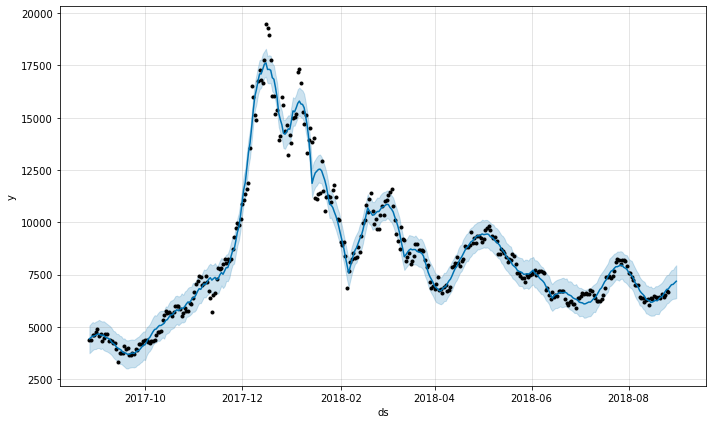

In [23]:
fig1 = prophet.plot(forecast_data)

- seasonality_mode로 설정했었던 기간별 트렌드 정보 시각화

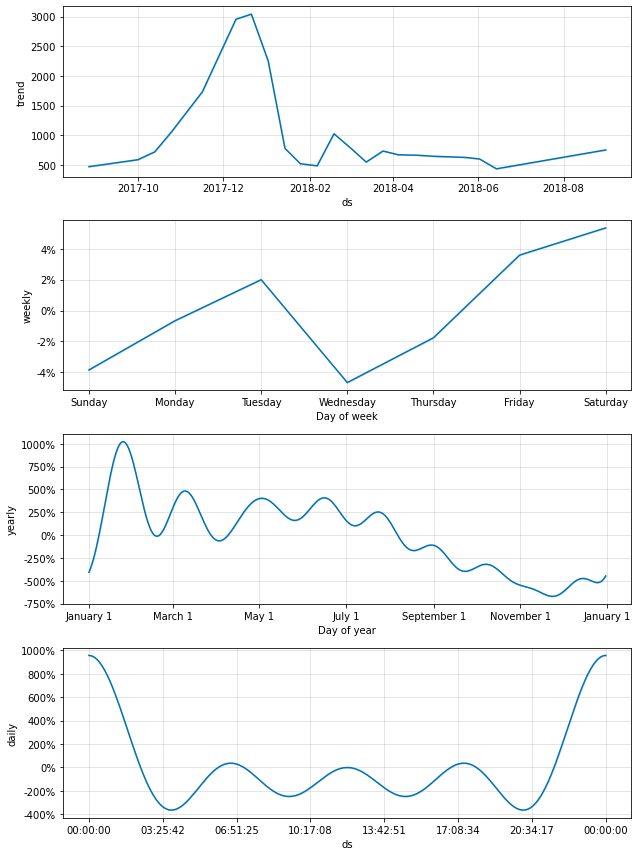

In [24]:
fig2 = prophet.plot_components(forecast_data)

-----

###### 모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산
- train RMSE 점수 : 521.5
- train r2 점수 (train 데이터에 대한 모델의 설명력) : 0.97

In [25]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터

In [26]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

522.2899311292591
0.9737786665877044


###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교
- 5일 후의 실제 데이터 : market-price-test.csv
- 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [27]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터(2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터(2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값

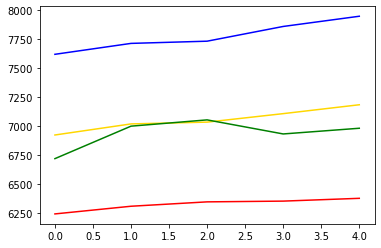

In [28]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

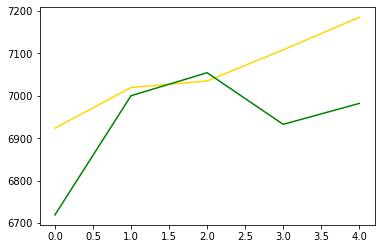

In [29]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

- test RMSE 점수 : 101.1

In [30]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

151.367832019998


-----

# 3. 더 나은 결과를 위한 방법들

### 상한가 및 하한가 선정
##### 상한가 적용을 위한 파라미터 설정
* additive(default)' or 'multiplicative'  
* Additive는 데이터의 진폭이 일정함을 의미 
* Multiplicative는 데이터의 진폭이 점점 증가하거나 감소하는 것을 뜻함.


In [31]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

bitcoin_df['cap'] = 20000 # 상한가 설정

# 상한가 적용을 위한 파라미터 설정.
prophet = Prophet(seasonality_mode='multiplicative',  
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

#Additive Seasonality : Time series = Trend + Seasonality + Error
    

In [32]:
# 5일후 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가 설정
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

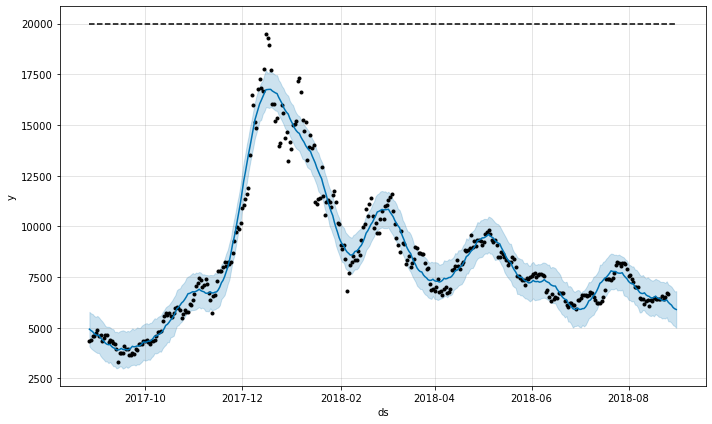

In [33]:
fig = prophet.plot(forecast_data)

###### 실제 데이터와의 비교

In [34]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터 가져옴
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

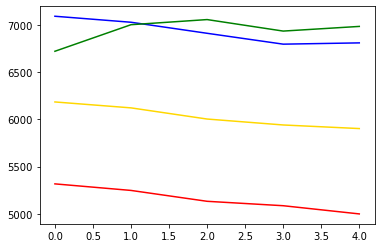

In [35]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

###### 실제 데이터와의 비교 결과
* 비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보임.
* 모델이 예측한 상한가(파란색) 보다 실제 가격(녹색)이 더 높다
* 5일 동안 상승/하락할 것이다라른 큰 범위 트렌드를 예측하는 것조차 실패
* 상한가라는 개념이 큰 의미가 없는 비트코인 데이터의 경우는 상한선 설정이 오히려 독

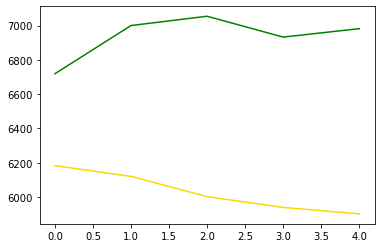

In [36]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

-----

- test RMSE 점수 : 910.36

In [37]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

929.2316828959192


### 모델의 성능을 향시키는 다른 방법
##### 이상치 제거하기
* 가격이 18000을 넘어가는 값을 이상치로 판단하여 제거 나머지는 부분은 이전과 동일

In [51]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

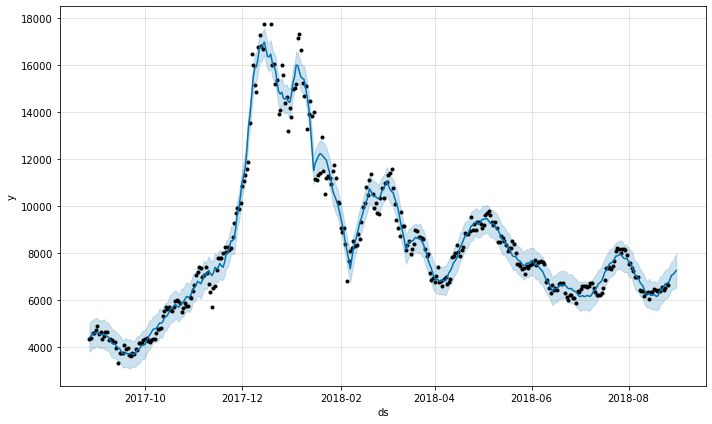

In [52]:
# prophet 모델을 학습
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력
fig = prophet.plot(forecast_data)

###### 실제 데이터와의 비교

In [53]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옴
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

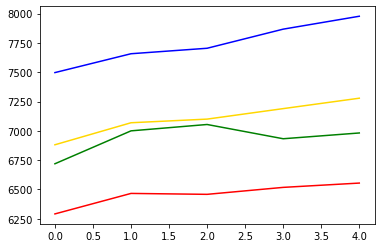

In [54]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

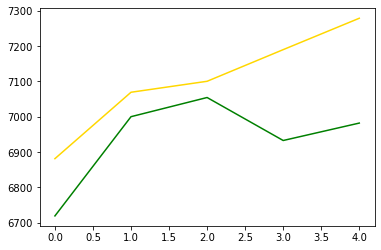

In [55]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

- test RMSE 점수 : 252.18

In [56]:
# 테스트 데이터의 RMSE를 출력
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

193.48291941379125


###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보임
- 모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있다.

# 재미로 알아보는 내일의 비트코인 시세

###### 좋은 예측력을 보였던 Prophet 모델로 향후 5일간의 비트코인 시세를 예측

In [48]:
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [49]:
# 5일후의 미래를 예측
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [50]:
# 테스트 데이터를 불러옴
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져옴
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

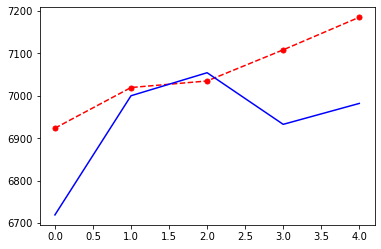

In [47]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프
plt.plot(test_y, color="blue") # 실제 가격 그래프

## Quiz_20201215
### 시계열 그래프 그리기
우리나라를 방문하는 상위 5개 국가별(중,일,대,미,홍)로 시계열 그래프로 나타내 보세요. 

In [124]:
import platform
# 한글 폰트 설치 
path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

# 마이너스 부호 표시 
plt.rcParams['axes.unicode_minus'] = False

In [130]:
df = pd.read_excel("../data/k_total.xlsx")
df.head()

,국적,관광,상용,공용,유학/연수,기타,계,기준년월,대륙,관광객비율(%),전체비율(%)
0,일본,202825,1750,89,549,3971,209184,2010-01,아시아,97.0,50.6
1,대만,35788,41,17,37,516,36399,2010-01,아시아,98.3,8.9
2,홍콩,13874,55,0,21,595,14545,2010-01,아시아,95.4,3.5
3,마카오,554,0,0,0,0,554,2010-01,아시아,100.0,0.1
4,태국,13374,39,13,53,4335,17814,2010-01,아시아,75.1,3.3


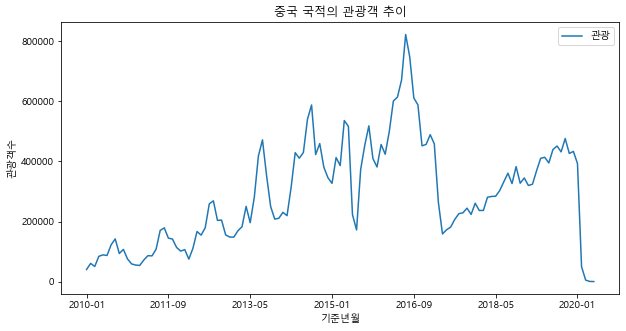

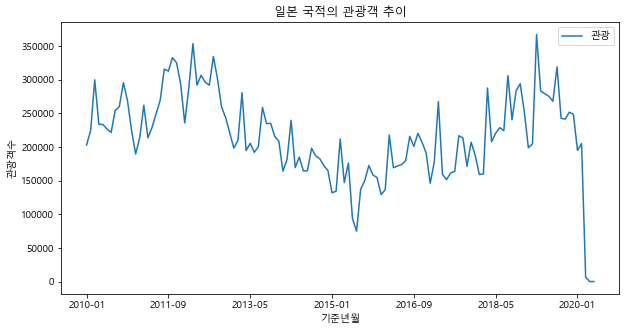

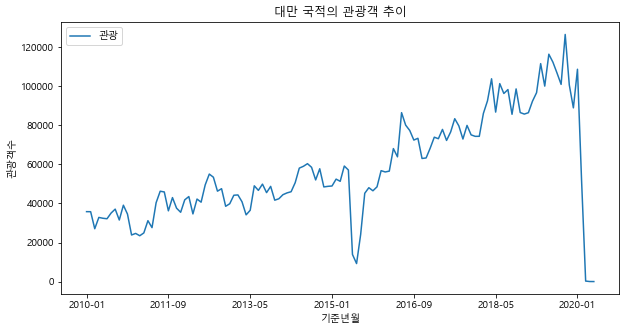

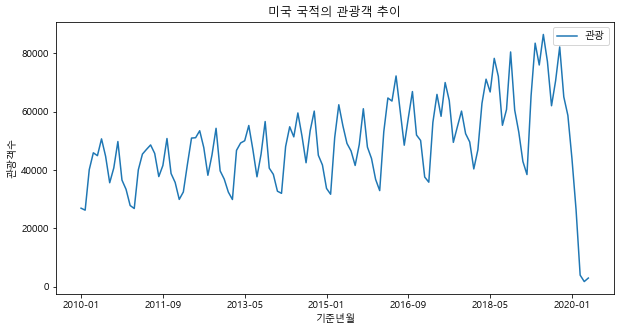

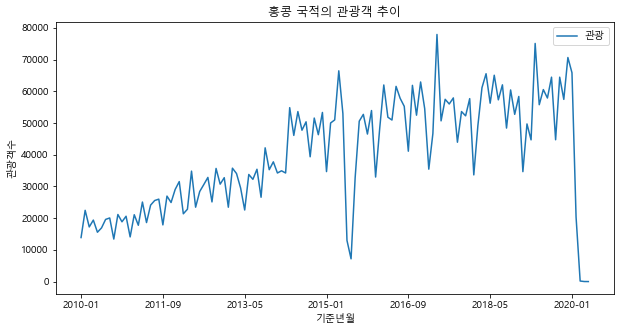

In [167]:
nationby = df.groupby('국적')['관광'].sum().reset_index()
top5 = nationby.sort_values(by = '관광', ascending = False).head(n = 5).reset_index(drop = True)
final = df[df['국적'].isin(top5['국적'].to_list())][['국적', '관광', '기준년월']]
final.reset_index(drop  = True)
final.set_index("기준년월", inplace = True)
for n in top5['국적'].to_list():
    final[final['국적']==n].plot(figsize=(10,5))
    plt.title(n+" 국적의 관광객 추이")
    plt.xlabel("기준년월")
    plt.ylabel("관광객수")

### 관광객 히트맵 그리기 

In [200]:
pv = final.reset_index()
pv['월'] = pv['기준년월'].apply(lambda x:x[5:])
pv.rename(columns = {'기준년월': '년도'}, inplace = True)

In [201]:
pv.head()

,년도,국적,관광,월
0,2010-01,일본,202825,01
1,2010-01,대만,35788,01
2,2010-01,홍콩,13874,01
3,2010-01,중국,40425,01
4,2010-01,미국,26943,01


In [202]:
pv['년도'] = pv['년도'].apply(lambda x:x[:4])

In [208]:
pv.head(), pv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   년도      625 non-null    object
 1   국적      625 non-null    object
 2   관광      625 non-null    int64 
 3   월       625 non-null    object
dtypes: int64(1), object(3)
memory usage: 19.7+ KB


(     년도  국적      관광   월
 0  2010  일본  202825  01
 1  2010  대만   35788  01
 2  2010  홍콩   13874  01
 3  2010  중국   40425  01
 4  2010  미국   26943  01,
 None)

In [234]:
tourmap = pv.pivot_table(index =["년도", "국적"],columns = "월", values = "관광",fill_value=0)
tourmap

월            01      02      03      04      05      06      07      08  \
년도   국적                                                                   
2010 대만   35788   35758   27050   32835   32405   32156   35086   37078   
     미국   26943   26268   40143   45939   44951   50711   44732   35671   
     일본  202825  224475  299820  233697  233311  226786  221590  254178   
     중국   40425   60590   50330   84252   89056   87080  122432  142180   
     홍콩   13874   22462   17226   19382   15552   16918   19599   20053   
2011 대만   24653   23463   24907   31169   27611   40344   46240   45863   
     미국   27866   26837   40121   45489   47110   48633   45717   37783   
     일본  189601  213970  262003  213645  229017  249397  269455  315693   
     중국   55070   53863   72003   86397   85668  108060  170524  178937   
     홍콩   14083   21075   17752   25070   18603   24111   25556   25987   
2012 대만   41833   43508   34633   42231   40636   49467   55007   53406   
     미국   29961   32504   42005   50988   51105   53498   47718   38228   
     일본  235585  287950  353455  291877  306488  296274  291787  334318   
     중국  106606   74895  110965  166843  154841  179074  258907  268988   
     홍콩   31524   21373   22805   34818   23450   28395   30578   32838   
2013 대만   44187   44332   40832   34151   36493   49003   46676   49872   
     미국   32468   29924   46779   49297   50073   55298   47032   37702   
     일본  198320  209621  280541  194611  205412  191995  200452  258870   
     중국  148118  169395  182850  250549  196306  280319  417991  472005   
     홍콩   23441   35752   34061   29494   22566   33766   32233   35408   
2014 대만   44459   45381   45981   50621   58051   58980   60327   58472   
     미국   32773   32037   48065   54859   51402   59597   51695   42524   
     일본  164038  181307  239575  169382  184996  164438  164741  198068   
     중국  230706  219533  313400  429419  410971  429991  540683  588181   
     홍콩   34232   34924   34230   54830   46081   53593   47721   50366   
2015 대만   48909   52425   51302   59129   57080   13892    9232   24095   
     미국   33727   31724   51156   62410   55214   49148   46563   41599   
     일본  131909  134366  211846  147108  176044   93726   74890  137125   
     중국  327225  413096  386386  536428  517154  223101  172075  372990   
     홍콩   34672   49996   50969   66444   52999   12968    7169   32775   
2016 대만   56752   56092   56515   68043   63833   86427   80041   77303   
     미국   36829   32972   53173   64733   63675   72286   60376   48543   
     일본  129290  136324  217623  169211  171675  173883  179569  215859   
     중국  456636  424232  500018  601460  614636  671493  823016  747818   
     홍콩   32956   48259   61980   51814   50925   61538   57771   55255   
2017 대만   68286   73874   73095   77848   72213   76552   83332   79663   
     미국   37630   35860   56367   65961   58444   70021   63853   49516   
     일본  146111  177671  267416  159263  151502  161395  163712  216683   
     중국  489256  458952  263788  158784  172527  181507  207099  226153   
     홍콩   54501   35438   46659   77904   50667   57461   55987   57902   
2018 대만   74322   86022   92453  103752   86712  101277   96238   98229   
     미국   40407   46981   62903   71177   66792   78313   72143   55367   
     일본  159174  159831  287578  207727  220375  228667  224273  306108   
     중국  236825  237075  281020  283533  284317  303405  332657  360982   
     홍콩   33634   49178   61129   65529   56234   65053   57295   62024   
2019 대만   86393   92276   96643  111505  100004  116323  112231  106682   
     미국   42989   38475   65448   83521   76044   86508   77224   62072   
     일본  198805  204697  367157  283101  279174  275286  267816  318985   
     중국  320113  324291  369165  410542  413949  395196  439699  451570   
     홍콩   34653   49695   44679   75074   55756   60526   57868   64438   
2020 대만  108623   51881     274      48      31       0       0       0   
     미국   43866   26407  

In [237]:
tourmap.filter(like='대만', axis = 0)

,월,01,02,03,04,05,06,07,08,09,10,11,12
년도,국적,,,,,,,,,,,,
2010,대만,35788,35758,27050,32835,32405,32156,35086,37078,31511,39087,34557,23851
2011,대만,24653,23463,24907,31169,27611,40344,46240,45863,36209,42980,37560,35468
2012,대만,41833,43508,34633,42231,40636,49467,55007,53406,46265,47538,38529,39837
2013,대만,44187,44332,40832,34151,36493,49003,46676,49872,45515,48720,41652,42373
2014,대만,44459,45381,45981,50621,58051,58980,60327,58472,52010,57729,48434,48737
2015,대만,48909,52425,51302,59129,57080,13892,9232,24095,45182,48039,46464,48484
2016,대만,56752,56092,56515,68043,63833,86427,80041,77303,72407,73306,62989,63245
2017,대만,68286,73874,73095,77848,72213,76552,83332,79663,72932,79902,75062,74306
2018,대만,74322,86022,92453,103752,86712,101277,96238,98229,85584,98567,86476,85697


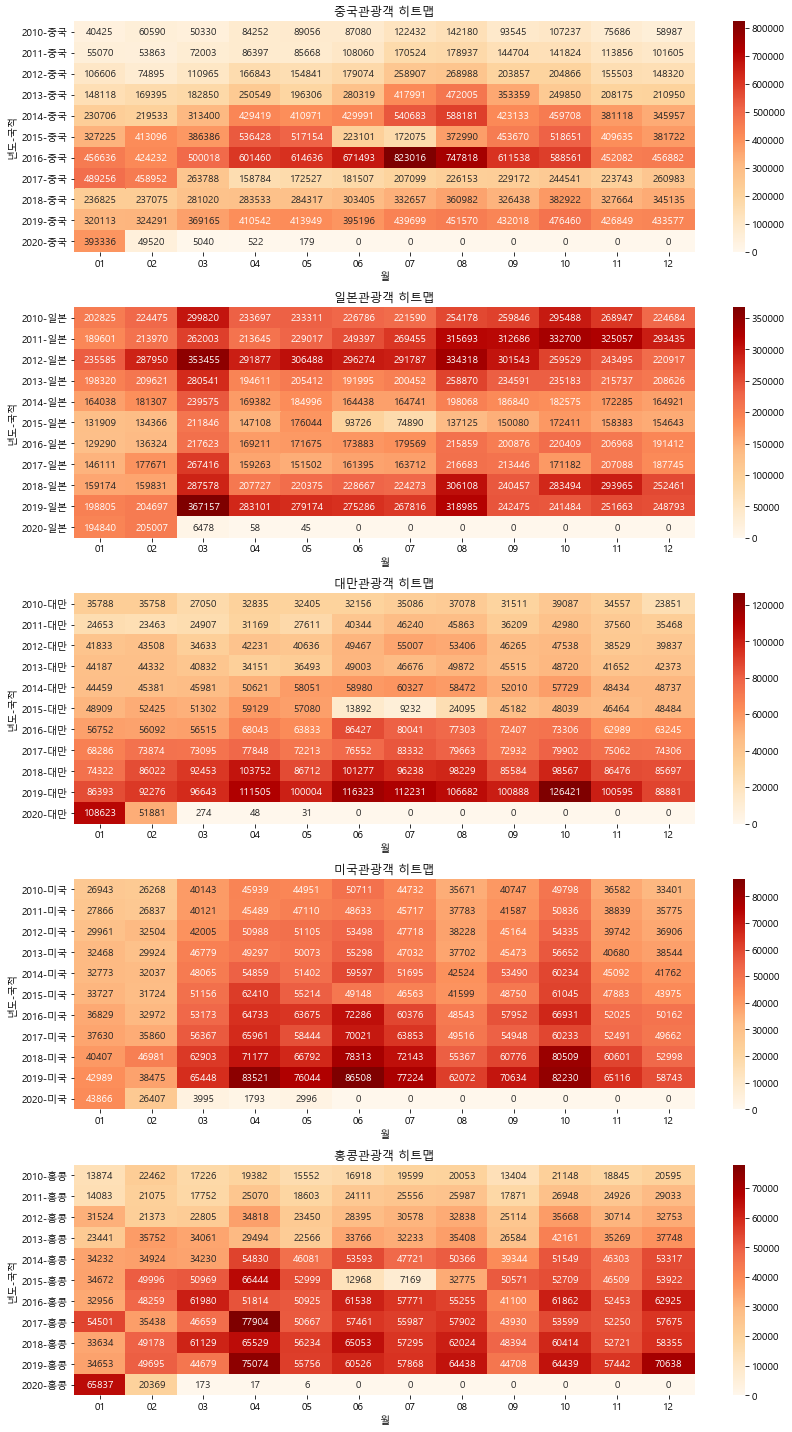

In [239]:
f, ax = plt.subplots(5,1, figsize=(12,20))
axe = ax.ravel()


for i, v in enumerate(top5['국적'].to_list()):
    tmp = tourmap.filter(like=v, axis = 0)
    sns.heatmap(tmp, annot=True, fmt="d", ax = axe[i], cmap = 'OrRd')  
    axe[i].set_title(v + '관광객 히트맵')
    f.tight_layout()